In [1]:
from __future__ import division, print_function
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.io import fits as pyfits

import sys

sys.path.append('/Users/tom/Projects/k2photo/code/')

In [3]:
import glob

from astropy.stats.funcs import median_absolute_deviation as MAD
from scipy.ndimage import label
from photo_test import raw_moment, intertial_axis, plot_bars

from kepfit import lsqclip
from martinsff import martinsff
import extract_lc

In [4]:
def bg_sub(fla):
    """
    subtract the background from a series of images
    by assuming the aperture is large enough to be
    predominantly background
    """
    for i in xrange(np.shape(fla)[0]):
        fla[i,:,:] = fla[i,:,:] - np.nanmedian(fla[i,:,:])
    return fla

In [5]:
fn = '/Users/tom/Projects/scox1/data/ktwo205703810-c02_spd-targ.fits.gz'
f = pyfits.open(fn)

In [6]:
bg_cut=5
skip = 0
time = f[1].data['TIME'][skip:] - f[1].data['TIME'][0]
fluxarr = f[1].data['FLUX'][skip:]
quality = f[1].data['QUALITY'][skip:]
#time = time[quality != 32800]
#fluxarr = fluxarr[quality != 32800,:,:]

time = time[quality == 0.]
fluxarr = fluxarr[quality == 0,:,:]

fluxarr[fluxarr == 0] = np.nan
flux_b = bg_sub(fluxarr)
flatim = np.nanmedian(flux_b,axis=0)
vals = flatim[np.isfinite(flatim)].flatten()
mad_cut = 1.4826 * MAD(vals) * bg_cut
region = np.where(flatim > mad_cut,1,0)
lab = label(region)[0]
imshape = np.shape(flatim)
centralpix = [1+imshape[0] // 2,1+imshape[1] // 2]
centflatim = flatim[centralpix[0]-4:centralpix[0]+4,
                centralpix[1]-4:centralpix[1]+4]
flatimfix = np.where(np.isfinite(centflatim),centflatim,0)
brightestpix = np.unravel_index(flatimfix.argmax(), centflatim.shape)
bpixy, bpixx = brightestpix
regnum = lab[centralpix[0]-4+bpixy,centralpix[1]-4+bpixx]
if regnum == 0:
    print('WARNING, no star was found in light curve, \
            {} light curve will be junk!'.format(fn))

lc = np.zeros_like(time)
xbar = np.zeros_like(time)
ybar = np.zeros_like(time) 

ymin = np.min(np.where(lab == regnum)[0])
ymax = np.max(np.where(lab == regnum)[0])
xmin = np.min(np.where(lab == regnum)[1])
xmax = np.max(np.where(lab == regnum)[1])
momlims = [ymin,ymax+1,xmin,xmax+1]

for i,fl in enumerate(fluxarr):
    lc[i] = np.sum(fl[lab == regnum])
    momim = fl[momlims[0]:momlims[1],
                momlims[2]:momlims[3]]
    momim[~np.isfinite(momim)] == 0.0
    xbar[i], ybar[i], cov = intertial_axis(momim)



/Users/tom/.virtualenvs/p1/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:612: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/Users/tom/.virtualenvs/p1/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater


In [7]:
_old_time = np.copy(time)
_old_lc = np.copy(lc)
_old_xbar = np.copy(xbar)
_old_ybar = np.copy(ybar)

m1 = np.isfinite(lc)
m2 = np.arange(len(time)) > 100

mask = m1 & m2

time = time[mask]
lc = lc[mask]
xbar = xbar[mask]
ybar = ybar[mask]
flatlc = extract_lc.medfilt(time,lc,window=3.)
zpt = len(time)%9000.

In [8]:
outflux, correction, thr_cad = extract_lc.run_C0_detrend(
                time,flatlc,xbar,ybar,cadstep=9000)

/Users/tom/Projects/k2photo/code/kepfit.py:98: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if (covar == None):
/Users/tom/Projects/k2photo/code/kepfit.py:102: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if (covar != None and len(coeffs) > 1):


In [9]:
not_thr = ~thr_cad
corflux = (lc[zpt:][not_thr]/
                    np.median(lc[zpt:][not_thr])/
                    correction[not_thr])
corflatflux = (flatlc[zpt:][not_thr]/
                    np.median(flatlc[zpt:][not_thr])/
                    correction[not_thr])

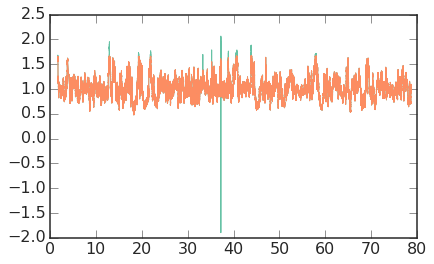

In [10]:
mad_cut = 1.4826 * MAD(corflatflux-1.) *4
keep = np.abs(corflatflux-1.) < mad_cut
plt.plot(time[zpt:][not_thr],corflatflux)
plt.plot(time[zpt:][not_thr][keep],corflatflux[keep])

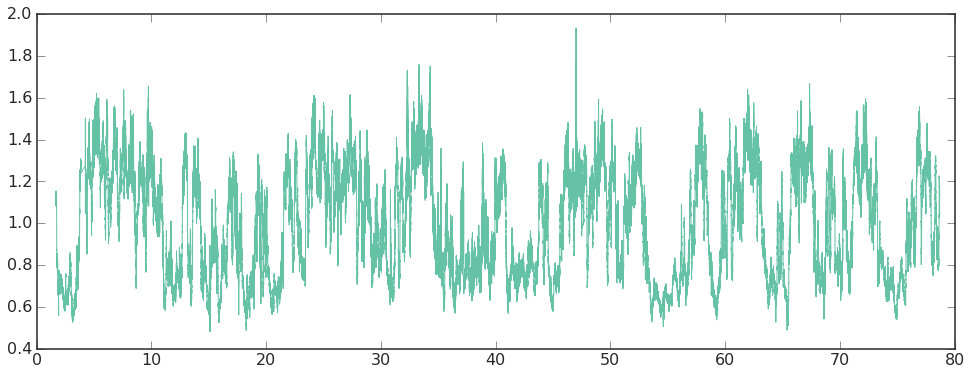

In [11]:
plt.figure(figsize=[15,6])
plt.plot(time[zpt:][not_thr][keep],corflux[keep])
#plt.xlim([40,50])

In [12]:
from scipy.signal import lombscargle as lomb
freqs = np.linspace(0.3, 100, 10000)
#freqs = np.linspace(22, 32, 10000)
df = (freqs[1] - freqs[0]) * 1.157E-5 * 1.E6
ivals = np.arange(0,len(time[zpt:][not_thr][keep]),5000)
outarr = np.zeros([len(ivals),len(freqs)])
for j,i in enumerate(ivals[:-1]):
    lv = lomb(time[zpt:][not_thr][keep][i:i+5000],corflatflux[keep][i:i+5000] - 1.0,freqs * 2. * np.pi)
    outarr[j] = np.sqrt(4*(lv/time[zpt:][not_thr][keep][i:i+5000].shape[0]))

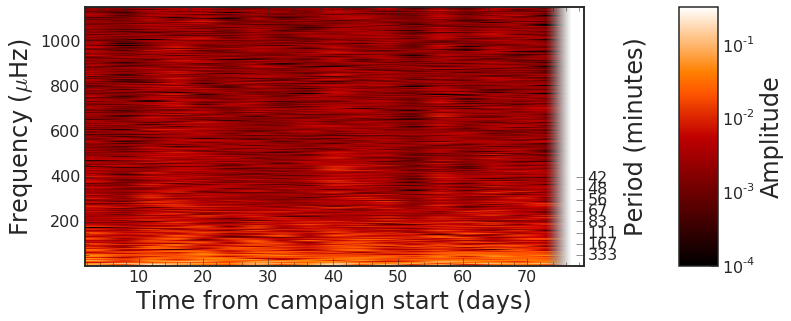

In [13]:
fig, ax = plt.subplots(1, 1, figsize=[11,4.5], sharex=True, sharey=True,)
ax.set_visible(False)
ax1 = fig.add_axes([0.1, 0.15, 0.63, 0.8])
im = ax1.imshow(outarr.T, origin='lower', aspect='auto', cmap=plt.cm.gist_heat,
          interpolation='spline16',
          extent=[time[zpt:][not_thr][keep][0], time[zpt:][not_thr][keep][-1], 
                  freqs[0]* 1.157E-5 * 1.E6, freqs[-1]* 1.157E-5 * 1.E6],
          norm=matplotlib.colors.LogNorm(),vmin=0.0001)
ax1.minorticks_on()
ax1.set_xlabel('Time from campaign start (days)')
ax1.set_ylabel('Frequency ($\mu$Hz)')

ax2 = ax1.twinx()
ax2.set_xlim([time[zpt:][not_thr][keep][0], time[zpt:][not_thr][keep][-1]])
ax2.set_ylim([freqs[0]* 1.157E-5 * 1.E6, freqs[-1]* 1.157E-5 * 1.E6])
#ax2.contour(outarr.T)
ax2.set_yticks(1440. *  1.E6 * 1.157E-5 / np.array([42,48,56,67,83,111,167,333]),minor=False)
ax2.set_yticklabels(np.array([42,48,56,67,83,111,167,333],dtype=str))
ax2.set_ylabel('Period (minutes)')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.8])
cb = fig.colorbar(im,cax=cbar_ax)
cb.set_label('Amplitude')
#savefig('scox1_')

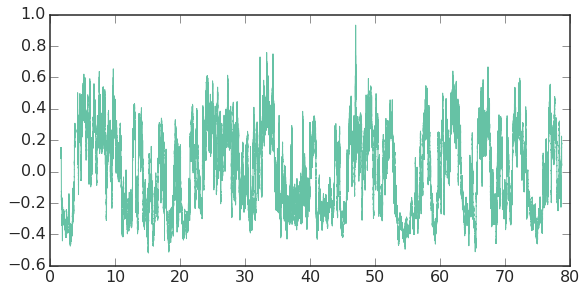

In [14]:
fig, ax = plt.subplots(1, 1, figsize=[8.5,4.5], sharex=True, sharey=True,)
plt.plot(time[zpt:][not_thr][keep],corflux[keep] - 1.0)

In [15]:
freqs = np.linspace(1, 2, 10000)
lv = lomb(time[zpt:][not_thr][keep],corflatflux[keep] - 1.0,freqs * 2. * np.pi)

0.78707493702770781

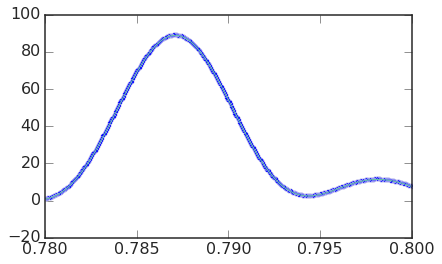

In [16]:
plt.plot(1./freqs,lv)
plt.scatter(1./freqs,lv)
plt.xlim([0.78,0.8])
np.argmax(lv)
1./freqs[2705]

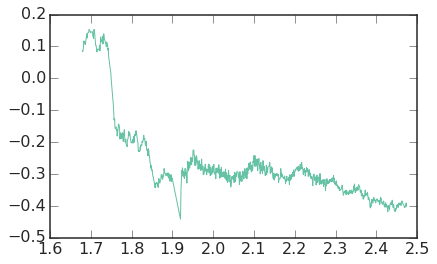

In [17]:
plt.plot(time[zpt:][not_thr][keep][0:0+1000],corflux[keep][0:0+1000] - 1.0)

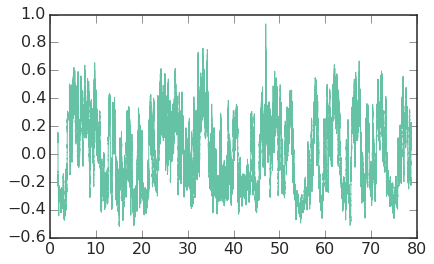

In [18]:
plt.plot(time[zpt:][not_thr][keep],corflux[keep] - 1.0)

(0, 10)

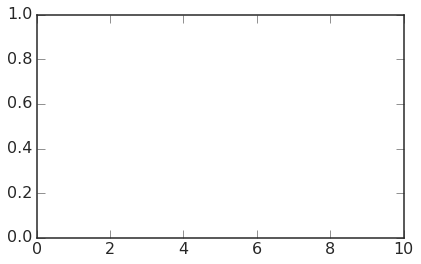

In [19]:

lomb(time[zpt:][not_thr][keep][i:i+10000],corflatflux[keep][i:i+10000] - 1.0,freqs * 2. * np.pi)
plt.xlim([0,10])

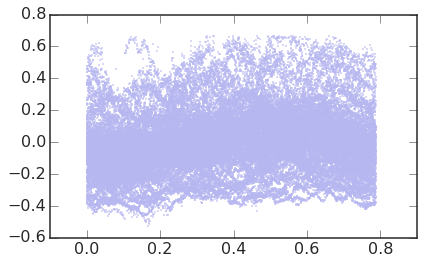

In [20]:
plt.scatter(time[zpt:][not_thr][keep]%0.787313,corflatflux[keep] - 1.0,s=1)

/Users/tom/.virtualenvs/p1/lib/python2.7/site-packages/matplotlib/axes/_axes.py:2663: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


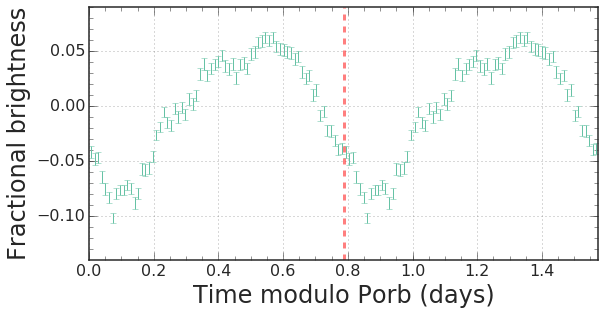

In [21]:
def std_samp(x):
    return np.std(x) / np.sqrt(len(x))


porb = 0.78707493702770781
N = len(corflatflux[keep])
total_bins = 70
Y = corflatflux[keep]
X = (time[zpt:][not_thr][keep]-3.15)%porb

import pandas as pd
df = pd.DataFrame({'X' : X, 'Y' : Y-1.0})  #we build a dataframe from the data

data_cut = pd.cut(df.X,total_bins)           #we cut the data following the bins
grp = df.groupby(by = data_cut)        #we group the data by the cut

ret = grp.aggregate(np.median)         #we produce an aggregate representation (median) of each bin
ret2 = grp.aggregate(std_samp)   

#plotting

#plt.scatter(np.r_[df.X,df.X+porb],np.r_[df.Y,df.Y],color='grey',alpha=.04,s=1)
#plt.scatter(df.X+porb,df.Y,color='k',alpha=.2,s=2)
fig, ax = plt.subplots(1, 1, figsize=[8.5,4.5], sharex=True, sharey=True,)
#plt.plot(np.r_[ret.X,ret.X+porb],np.r_[ret.Y,ret.Y],'r--',lw=3,alpha=.9)
plt.errorbar(np.r_[ret.X,ret.X+porb],np.r_[ret.Y,ret.Y],np.r_[ret2.Y,ret2.Y],fmt=None)

plt.xlim([0.0,2*porb])
plt.ylim([-0.14,0.09])
plt.axvline(x=porb,ymin=0,ymax=1, ls='--', color='red', lw=3,alpha=0.5)
plt.minorticks_on()
plt.grid()
plt.xlabel('Time modulo Porb (days)')
plt.ylabel('Fractional brightness')
plt.tight_layout()
#fig.savefig('scox1_folded.png',dpi=150)

In [22]:
t = np.genfromtxt('/Users/tom/Downloads/lc_1orbit-Sco_X-1_56892-56972.csv',delimiter=',').T
s = np.genfromtxt('/Users/tom/Downloads/lc_1day-Sco_X-1_56892-56972.csv',delimiter=',').T

(0, 80)

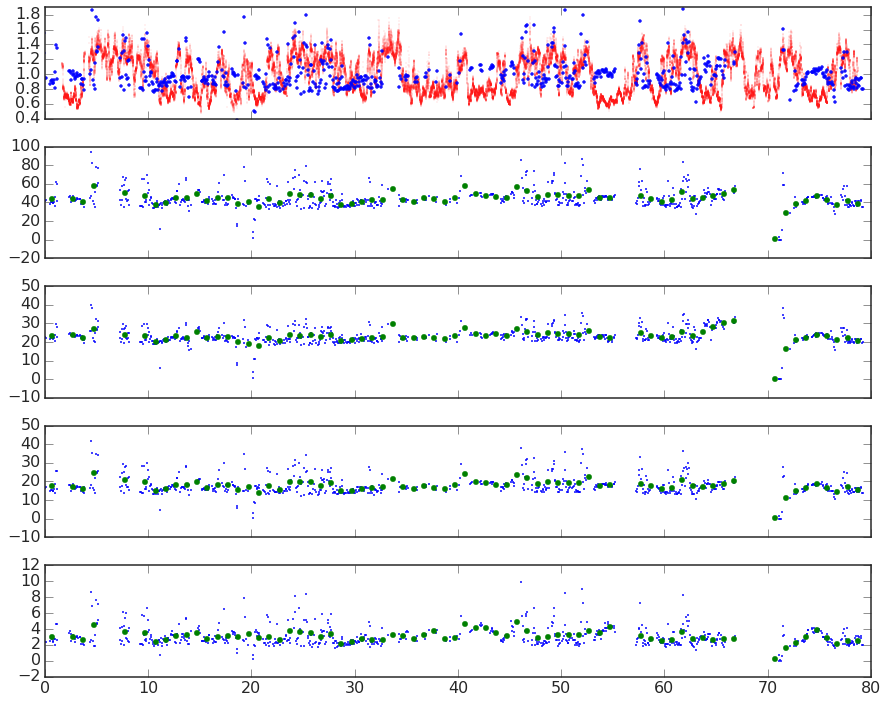

In [23]:
fig, [ax1,ax2,ax3,ax4,ax5] = plt.subplots(5, 1, figsize=[13.5,12], sharex=True, sharey=False,)
ax1.scatter(time[zpt:][not_thr][keep],corflux[keep],color='red',s=1,alpha=0.1)
ax2.scatter(t[0]+2400000.5-2454833-f[1].data['TIME'][0],t[1],color='b',s=2)
ax3.scatter(t[0]+2400000.5-2454833-f[1].data['TIME'][0],t[3],color='b',s=2)
ax4.scatter(t[0]+2400000.5-2454833-f[1].data['TIME'][0],t[5],color='b',s=2)
ax5.scatter(t[0]+2400000.5-2454833-f[1].data['TIME'][0],t[7],color='b',s=2)

ax2.scatter(s[0]+2400000.5-2454833-f[1].data['TIME'][0],s[1],color='g',s=28)
ax3.scatter(s[0]+2400000.5-2454833-f[1].data['TIME'][0],s[3],color='g',s=28)
ax4.scatter(s[0]+2400000.5-2454833-f[1].data['TIME'][0],s[5],color='g',s=28)
ax5.scatter(s[0]+2400000.5-2454833-f[1].data['TIME'][0],s[7],color='g',s=28)


#ax1.scatter(s[0]+2400000.5-2454833-f[1].data['TIME'][0],s[1]/np.median(s[1]),color='g',s=28)
ax1.scatter(t[0]+2400000.5-2454833-f[1].data['TIME'][0],t[1]/np.median(s[1]),color='b',s=8,alpha=0.9)
ax1.set_ylim([0.4,1.9])
plt.xlim([0,80])

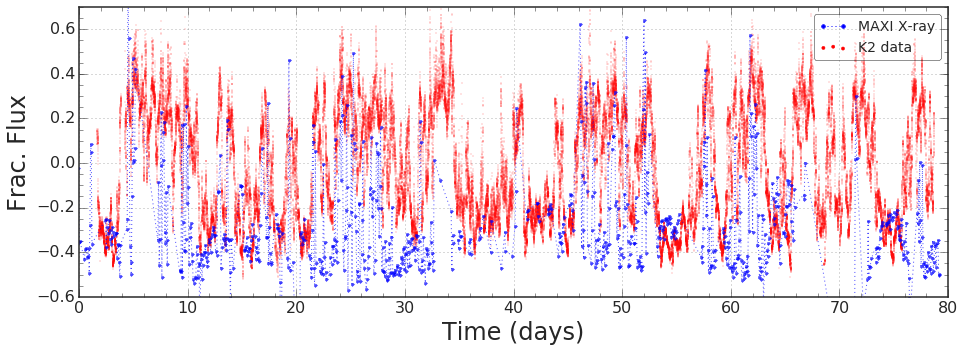

In [24]:
fig, ax1 = plt.subplots(1, 1, figsize=[13.5,5], sharex=True, sharey=False,)


#ax1.scatter(s[0]+2400000.5-2454833-f[1].data['TIME'][0],s[1]/np.median(s[1]),color='g',s=28)
ax1.plot(t[0]+2400000.5-2454833-f[1].data['TIME'][0],- 1.3 + t[1]/np.median(s[1]),'b.:',alpha=0.7, 
         )
ax1.scatter(time[zpt:][not_thr][keep],corflux[keep]-1.0,color='red',s=1,alpha=0.2,
           )
ax1.plot([-5,-6],[-5,-6],'b.:',alpha=1.,label='MAXI X-ray',ms=8,)
ax1.scatter([-5,-6],[-5,-6],color='red',s=10,alpha=1.,label='K2 data')

ax1.set_ylim([-0.6,0.7])
plt.xlim([0,80])
ax1.grid()
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Frac. Flux')
ax1.legend()
ax1.minorticks_on()
fig.tight_layout()
#fig.savefig('scox1_K2X.png',dpi=150)

In [25]:
np.savetxt('scox1_xray.txt',
           np.array([t[0]+2400000.5-2454833-f[1].data['TIME'][0],- 1.0 + t[1]/np.median(s[1])]).T)

In [26]:
np.savetxt('scox1_K2.txt',np.array([time[zpt:][not_thr][keep],corflux[keep]-1.0]).T)
           

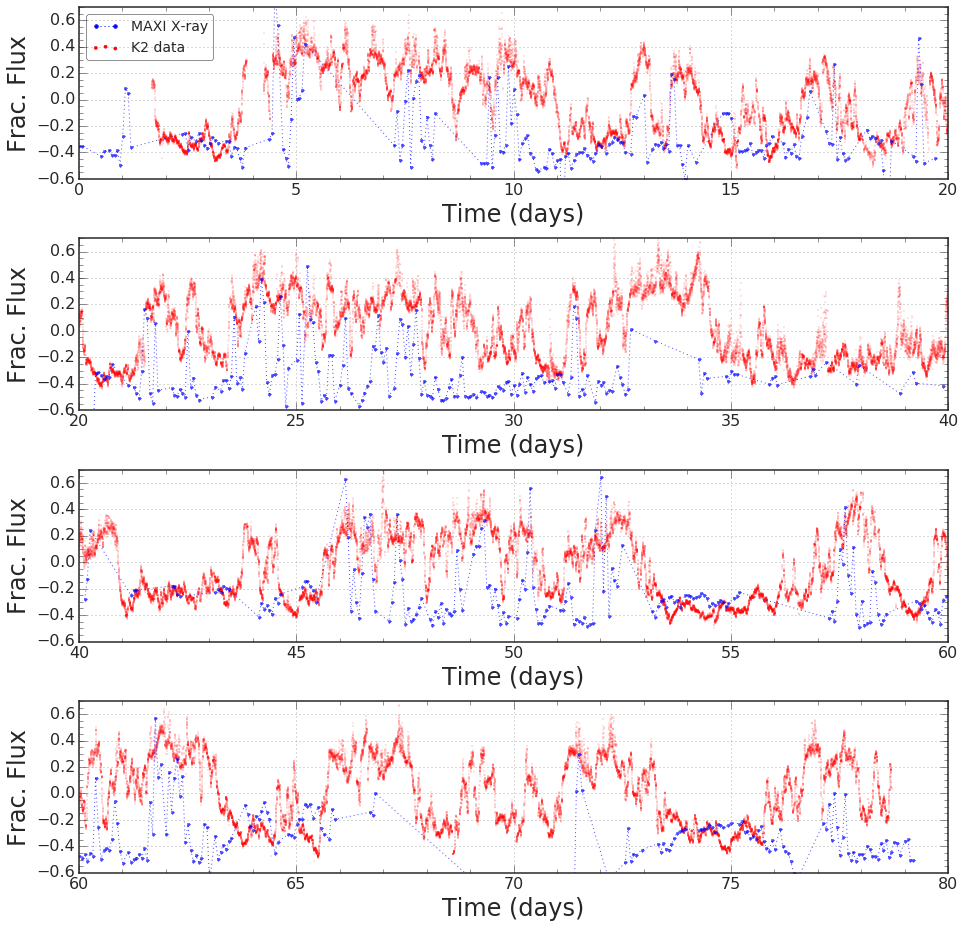

In [27]:
fig, axes = plt.subplots(4, 1, figsize=[13.5,13], sharex=False, sharey=True,)
[ax1,ax2,ax3,ax4] = axes

tx = t[0]+2400000.5-2454833-f[1].data['TIME'][0]
fx = - 1.3 + t[1]/np.median(s[1])
to = time[zpt:][not_thr][keep]
fo = corflux[keep]-1.0


#ax1.plot(tx,fx,'b.:',alpha=0.7)
#ax1.scatter(to,fo,color='red',s=1,alpha=0.2)

for i,ax in enumerate(axes):
    maskx = (tx >= i*20) & (tx <= i*20 + 20)
    masko = (to >= i*20) & (to <= i*20 + 20)
    ax.plot(tx[maskx],fx[maskx],'b.:',alpha=0.7)
    ax.scatter(to[masko],fo[masko],color='red',s=1,alpha=0.2)
    ax.set_xlim(i*20,i*20 + 20)
    ax.minorticks_on()
    ax.grid()
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Frac. Flux')

ax1.plot([-5,-6],[-5,-6],'b.:',alpha=1.,label='MAXI X-ray',ms=8,)
ax1.scatter([-5,-6],[-5,-6],color='red',s=10,alpha=1.,label='K2 data')

ax1.set_ylim([-0.6,0.7])
#plt.xlim([0,80])
#ax1.grid()


ax1.legend(loc=2)
#ax1.minorticks_on()
fig.tight_layout()
fig.savefig('scox1_K2X_panels.png',dpi=150)

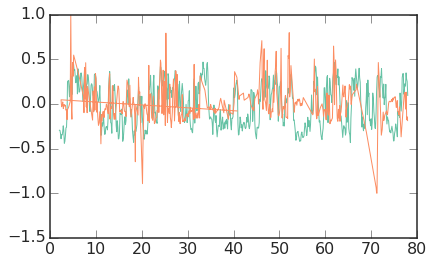

In [28]:
total_bins = 480
total_bins = np.linspace(2,78,640)

tx = t[0]+2400000.5-2454833-f[1].data['TIME'][0]
fx =  t[1]/np.median(s[1])
to = time[zpt:][not_thr][keep]
fo = corflux[keep]

Y = fo
X = to

import pandas as pd
df = pd.DataFrame({'X' : X, 'Y' : Y-1.0})  #we build a dataframe from the data

data_cut = pd.cut(df.X,total_bins)           #we cut the data following the bins
grp = df.groupby(by = data_cut)        #we group the data by the cut

ret = grp.aggregate(np.median)         #we produce an aggregate representation (median) of each bin
 
Y = fx
X = tx

import pandas as pd
df = pd.DataFrame({'X' : X, 'Y' : Y-1.0})  #we build a dataframe from the data

data_cut = pd.cut(df.X,total_bins)           #we cut the data following the bins
grp = df.groupby(by = data_cut)        #we group the data by the cut

ret2 = grp.aggregate(np.median)  


plt.plot(ret.X,ret.Y,)
plt.plot(ret2.X,ret2.Y,)

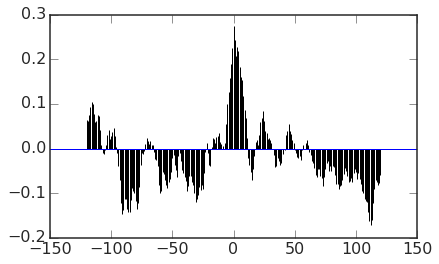

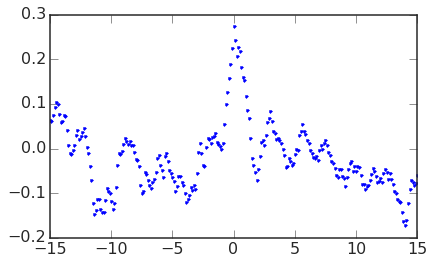

In [29]:
#plt.plot(np.correlate(ret.Y,ret2.Y,"same", old_behavior =True))
q = plt.xcorr(ret.Y,ret2.Y,maxlags=120)
plt.figure()
plt.plot(q[0]*0.125,q[1],'b.')

In [30]:
(80/640) 

0.125

In [22]:
#np.savetxt('scox1_uncorrlc.txt',np.array([time,lc]).T)



#plt.scatter(time[zpt:][not_thr],lc[zpt:][not_thr])
#fig = plt.figure(figsize=[13,7])
#plt.scatter(time[zpt:][not_thr],corflux,s=5)

In [21]:
import gatspy
def freq_grid(t, oversampling=5, nyquist_factor=3):
    T = t.max() - t.min()
    N = len(t)
    
    df = 1. / (oversampling * T)
    fmax = 0.5 * nyquist_factor * N / T
    N = int(fmax // df)
    return df + df * np.arange(N)





684525


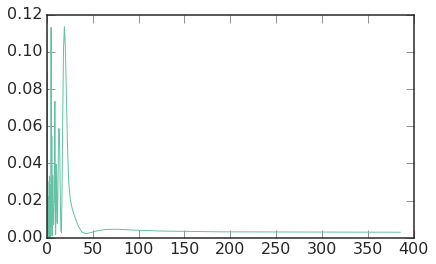

In [22]:
freq = freq_grid(time[zpt:][not_thr])
print(len(freq))

#from gatspy.periodic import LombScargle
from gatspy.periodic import LombScargleFast
model = LombScargleFast().fit(time[zpt:][not_thr], corflux, np.ones_like(corflux)*1.E-4)
period = 1. / freq
power = model.periodogram(period)
plt.plot(period, power)
#plt.xlim(0, 5);





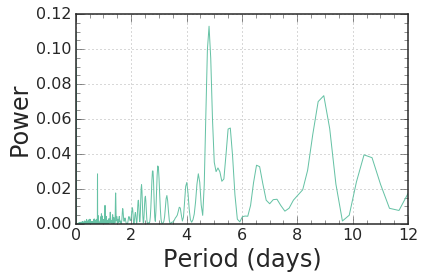

In [31]:
plt.plot(period, power)
plt.xlim([0,12])
plt.grid()
plt.minorticks_on()
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.tight_layout()
plt.savefig('scox1_periodogram.png')


In [35]:
model = LombScargleFast().fit(time[zpt:][not_thr], corflux, np.ones_like(corflux)*1.E-4)

In [37]:
model.optimizer.period_range = (4.7, 5.0)

In [38]:
model.best_period

Finding optimal frequency:
 - Estimated peak width = 0.0816
 - Using 5 steps per peak; omega_step = 0.0163
 - User-specified period range:  4.7 to 5
 - Computing periods at 6 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


4.808936772017792

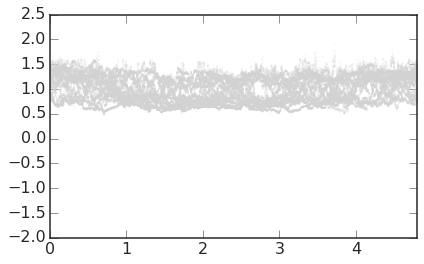

In [55]:
plt.scatter(time[zpt:][not_thr] % 4.808936772017792, corflux,s=0.1,c='k')
plt.xlim(0,4.8)
from gatspy.periodic import SuperSmoother

ssm = SuperSmoother().fit(time[zpt:][not_thr], corflux, np.ones_like(corflux)*1.E-4)
p  = ssm.predict(np.arange(0,5,0.1),period=4.808936772017792)

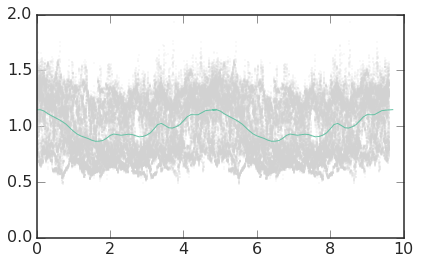

In [71]:
plt.scatter(np.r_[time[zpt:][not_thr] % 4.808936772017792,
                 (time[zpt:][not_thr] % 4.808936772017792)+4.8], np.r_[corflux,corflux],s=0.1,c='k')
plt.xlim(0,5*2)
plt.ylim(0,2)
plt.plot(np.r_[np.arange(0,5,0.1),np.arange(0,5,0.1)+4.8],np.r_[p,p])